In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


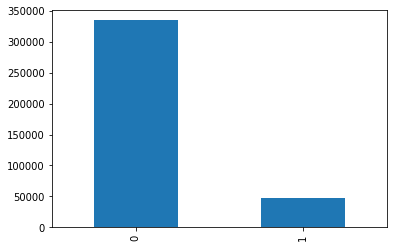

In [ ]:
train.Response.value_counts().plot(kind='bar')

In [ ]:
train.shape, test.shape

((381109, 12), (127037, 11))

In [ ]:
combine = train.append(test)
combine.shape

(508146, 12)

In [ ]:
keys=combine['Region_Code'].value_counts().keys()
values=combine['Region_Code'].value_counts().values
dict={}
for i in range(len(keys)):
  dict[keys[i]]=values[i]
combine['Region_Code']=combine['Region_Code'].map(dict)

In [ ]:
gender_map={'Male':1,'Female':0}
vehicleage_map={'> 2 Years':3, '1-2 Year':1, '< 1 Year':0}
vehicledamage_map={'No':0, 'Yes':1}
combine['Gender']=combine['Gender'].map(gender_map)
combine['Vehicle_Age']=combine['Vehicle_Age'].map(vehicleage_map)
combine['Vehicle_Damage']=combine['Vehicle_Damage'].map(vehicledamage_map)

In [ ]:
combine.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup
0,1,1,44,1,141937,0,3,1,40454.0,26,217,1.0,1
1,2,1,76,1,12349,0,1,0,33536.0,26,183,0.0,1
2,3,1,47,1,141937,0,3,1,38294.0,26,27,1.0,1
3,4,1,21,1,12328,1,0,0,28619.0,152,203,0.0,0
4,5,0,29,1,24400,1,0,0,27496.0,152,39,0.0,0


In [ ]:
(combine['Policy_Sales_Channel']=combine['Policy_Sales_Channel'].astype(int)
combine['Region_Code']=combine['Region_Code'].astype(int)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms=MinMaxScaler()
combine['Annual_Premium']=mms.fit_transform(np.array(combine['Annual_Premium']).reshape(-1,1))

In [ ]:
combine.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,AgeGroup
0,1,1,44,1,28,0,3,1,40454.0,26,217,1.0,adults
1,2,1,76,1,3,0,1,0,33536.0,26,183,0.0,adults
2,3,1,47,1,28,0,3,1,38294.0,26,27,1.0,adults
3,4,1,21,1,11,1,0,0,28619.0,152,203,0.0,teens
4,5,0,29,1,41,1,0,0,27496.0,152,39,0.0,teens


In [ ]:
combine['Policy_Sales_Channel'].value_counts()

152    179523
26     106594
124     98299
160     29090
156     14313
        ...  
149         1
84          1
141         1
41          1
142         1
Name: Policy_Sales_Channel, Length: 157, dtype: int64

In [ ]:
X = combine[combine['Response'].isnull()!=True].drop(['id','Response','Driving_License'], axis=1)
y = combine[combine['Response'].isnull()!=True]['Response']

X_test = combine[combine['Response'].isnull()==True].drop(['id','Response','Driving_License'], axis=1)

X.shape, y.shape, X_test.shape

((381109, 10), (381109,), (127037, 10))

In [ ]:
from imblearn.combine import SMOTETomek
# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42,sampling_strategy='minority',ratio=0.3)
X_res,y_res=smk.fit_sample(X,y)
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0.0: 334399, 1.0: 46710})
Resampled dataset shape Counter({0.0: 316992, 1.0: 82912})


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.05,random_state=42)

In [ ]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(max_depth=5,
                       learning_rate=0.4, 
                       n_estimators=1000)

model.fit(x_train,y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          eval_metric='auc',
          early_stopping_rounds=200,
          verbose=200)

pred_y = model.predict_proba(x_val)[:,1]
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
print(roc_auc_score(y_val, pred_y))

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.948901	training's binary_logloss: 0.202873	valid_1's auc: 0.941236	valid_1's binary_logloss: 0.211747
Early stopping, best iteration is:
[175]	training's auc: 0.947958	training's binary_logloss: 0.20431	valid_1's auc: 0.941509	valid_1's binary_logloss: 0.211659
0.9415086501091265


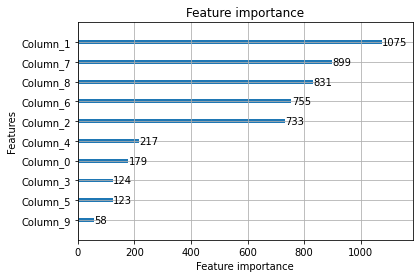

In [ ]:
import lightgbm
lightgbm.plot_importance(model)

In [ ]:
err = []
y_pred_tot_lgm = []

from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5)
i = 1
for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = LGBMClassifier(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.06,
                       n_estimators=1000,
                       min_child_weight=0.01,
                       colsample_bytree=0.5,
                       random_state=1994)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          eval_metric='auc',
          verbose=200)
    pred_y = m.predict_proba(x_val)[:,1]
    print("err_lgm: ",roc_auc_score(y_val,pred_y))
    err.append(roc_auc_score(y_val, pred_y))
    pred_test = m.predict_proba(X_test)[:,1]
    i = i + 1
    y_pred_tot_lgm.append(pred_test)

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.862348	training's binary_logloss: 0.261819	valid_1's auc: 0.85886	valid_1's binary_logloss: 0.264279
[400]	training's auc: 0.867381	training's binary_logloss: 0.258739	valid_1's auc: 0.859186	valid_1's binary_logloss: 0.264096
Early stopping, best iteration is:
[327]	training's auc: 0.865652	training's binary_logloss: 0.259721	valid_1's auc: 0.859246	valid_1's binary_logloss: 0.26404
err_lgm:  0.8592456115382606
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.862381	training's binary_logloss: 0.261933	valid_1's auc: 0.858943	valid_1's binary_logloss: 0.263817
[400]	training's auc: 0.867114	training's binary_logloss: 0.25909	valid_1's auc: 0.859294	valid_1's binary_logloss: 0.263542
Early stopping, best iteration is:
[328]	training's auc: 0.865483	training's binary_logloss: 0.260011	valid_1's auc: 0.859328	valid_1's binary_logloss: 0.263542
err_lgm:  0.8593283325

In [ ]:
np.mean(err,0)

0.8582544503570391

In [ ]:
from xgboost import XGBClassifier

errxgb = []
y_pred_tot_xgb = []

from sklearn.model_selection import KFold,StratifiedKFold

fold = StratifiedKFold(n_splits=5)
i = 1
for train_index, test_index in fold.split(X_res,y_res):
    x_train, x_val = X_res[train_index], X_res[test_index]
    y_train, y_val = y_res[train_index], y_res[test_index]
    m = XGBClassifier(boosting_type='gbdt',
                      max_depth=5,
                      learning_rate=0.07,
                      n_estimators=5000,
                      random_state=1994)
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          eval_metric='auc',
          verbose=200)
    pred_y = m.predict_proba(x_val)[:,1]
    print("err_xgb: ",roc_auc_score(y_val,pred_y))
    errxgb.append(roc_auc_score(y_val, pred_y))
    pred_test = m.predict_proba(X_test)[:,1]
    i = i + 1
    y_pred_tot_xgb.append(pred_test)

[0]	validation_0-auc:0.913248	validation_1-auc:0.818392
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[200]	validation_0-auc:0.975514	validation_1-auc:0.851118
[400]	validation_0-auc:0.982568	validation_1-auc:0.850425
Stopping. Best iteration:
[297]	validation_0-auc:0.981499	validation_1-auc:0.851491

err_xgb:  0.851490802716327


ValueError: ignored

In [ ]:
np.mean(errxgb,0)

0.8581976002449151

In [ ]:
(np.mean(errxgb, 0) + np.mean(err, 0))/2

0.8583584254865178

In [ ]:
model.predict_proba(X_test)[:,1]

array([3.75774852e-05, 3.41005749e-01, 2.64412789e-01, ...,
       1.23818869e-07, 5.20995700e-06, 1.29332069e-03])

In [ ]:
submission = pd.DataFrame()
submission['id'] = combine[combine['Response'].isnull()==True]['id']
submission['Response'] = model.predict_proba(X_test)[:,1]
submission.to_csv('check_02.csv', index=False, header=True)
submission.head()

,id,Response
0,381110,3.757749e-05
1,381111,3.410057e-01
2,381112,2.644128e-01
3,381113,3.213174e-07
4,381114,1.231867e-07
